<a href="https://colab.research.google.com/github/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/blob/main/MR%20_sequence_fundamentals_using_Pulseq/PULSEQ_GRE_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MR Sequence Fundamentals Using Pulseq: **Demo 2D GRE sequence**


Session: Hands-On Open-Source MR: From Pulse Sequence Programming to Reconstruction & Analysis



In this example we will follow the basic steps to build a 2D GRE sequence:
1. Define MR system hardware limits (mr.Opts)
2. Create sequence object (mr.Sequence(system))
3. Generate elements (e.g. gx:  mr.make_trapezoid)
4. Add blocks (e.g. Block 1: RF, gz: addblock(rf,gz))

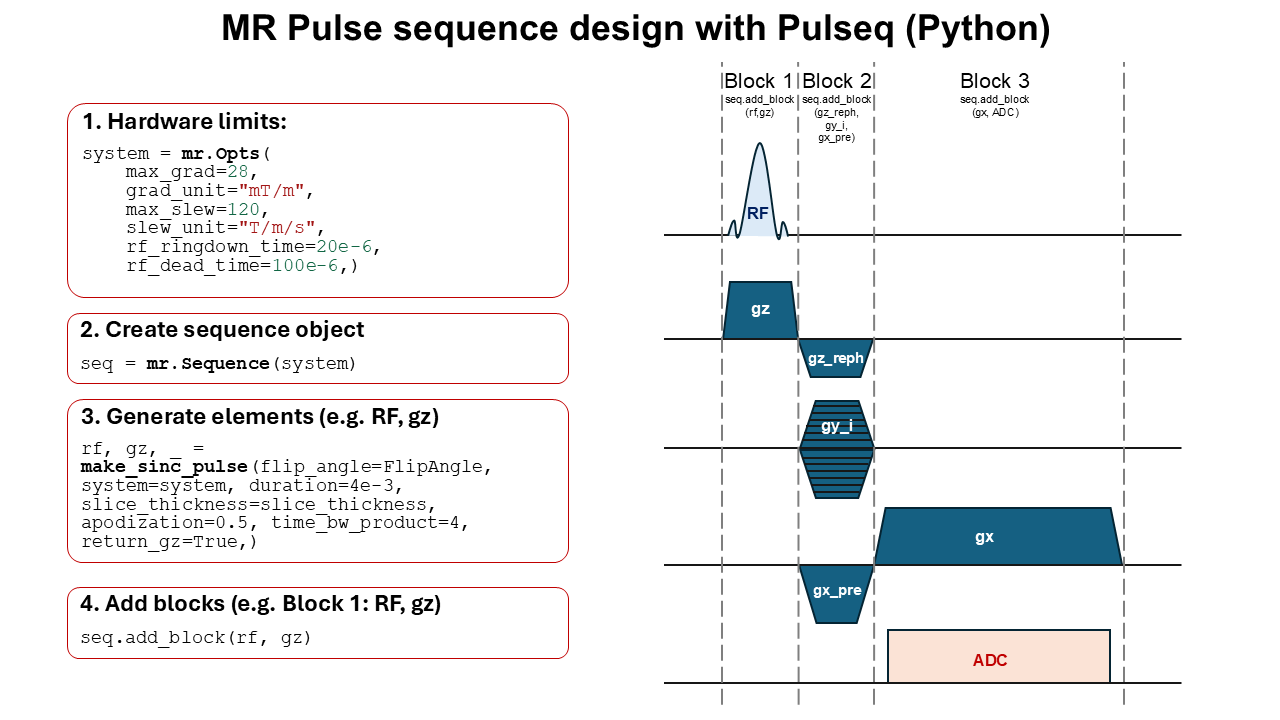

In [21]:
!pip install pypulseq

In [22]:
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr
from pickle import TRUE

## Setup sequence

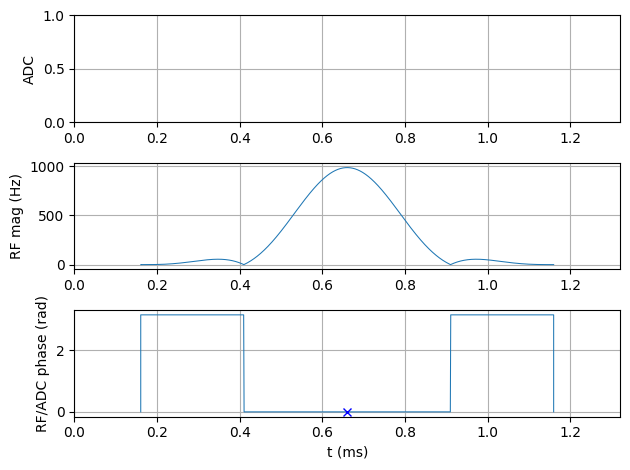

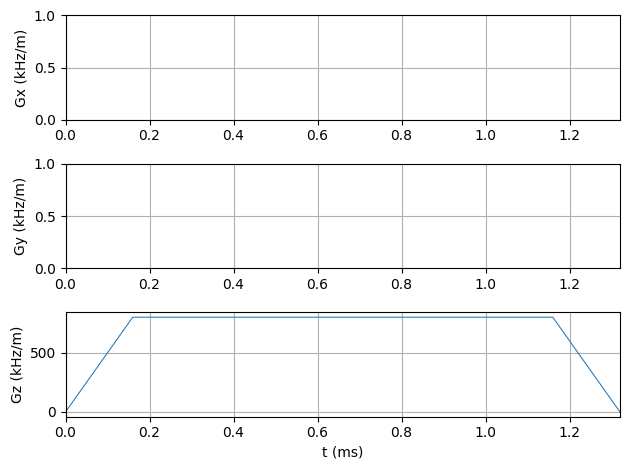

In [23]:
# SETUP
fov=256e-3 # mm
dwell=10e-5 # s
Nread=64    # number of points in the readout direction
Nphase=1    # number of lines (phase encoding direction)
TE=5e-3     # Echo Time
TR=60e-3    # Repetition Time

# Set system limits according with specific hardware
system = mr.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=120,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,)

# Create 90 degree slice selection RF sic pulse and gradient
rf, gz, _ = mr.make_sinc_pulse( flip_angle=90 * np.pi / 180,
                               system=system, duration=1e-3,
                                slice_thickness=5e-3, apodization=0.5,
                                time_bw_product=4, phase_offset=0*np.pi/180,
                                return_gz=True, delay=100e-6,)

# Generate sequence object according with system limits
seq = mr.Sequence(system)

#Add Block 1: rf and respective gradient gz for slice selection
seq.add_block(rf, gz)

#Display Block 1: rf and respective gradient gz for slice selection
seq.plot(time_disp='ms')




## Building Blocks
#    Block 2
     - gz_rep - gradient in z direction
     - gx_pre - prephase gradient in x direction (frequency encoding)
     - gy - gradient in y direction (phase encoding)
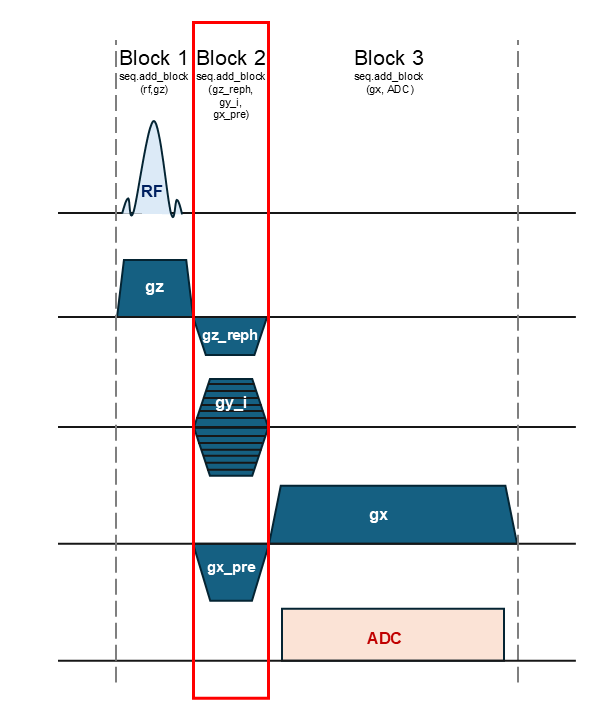


#    Block 3
     - gx - gradient in readout direction
     - ADC

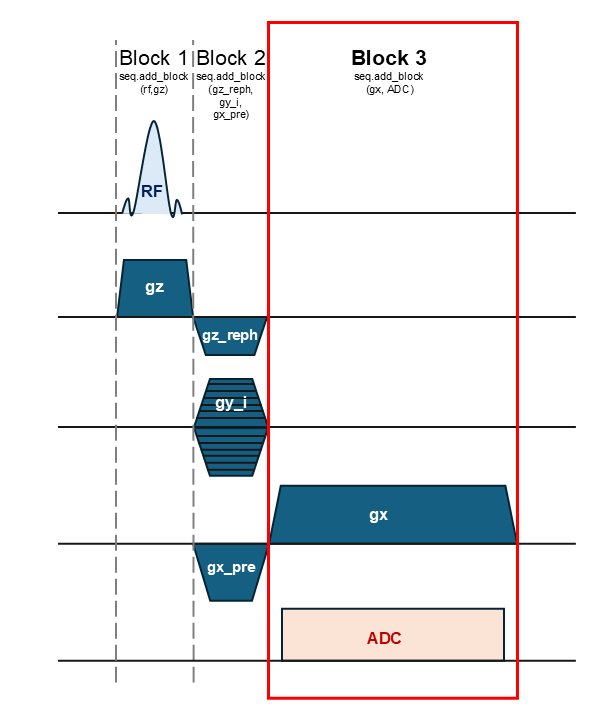

In [24]:
# Block 2
gy_0 = mr.make_trapezoid(channel='y', area=0, duration=mr.calc_duration(gx_pre),
                         system=system)
gz_reph = mr.make_trapezoid(channel='z', area=-gz.area/2, duration=mr.calc_duration(gx_pre),
                         system=system)
# Block 2 and 3
gx =mr.make_trapezoid(channel='x', flat_area=Nread/fov,flat_time=Nread*dwell)
gx_pre =mr.make_trapezoid(channel='x', area=-gx.area/2,duration=1e-3)

# Block 3
adc = mr.make_adc(
    num_samples=Nread,
    duration=Nread*dwell,
    phase_offset=0* np.pi / 180,
    system=system,)




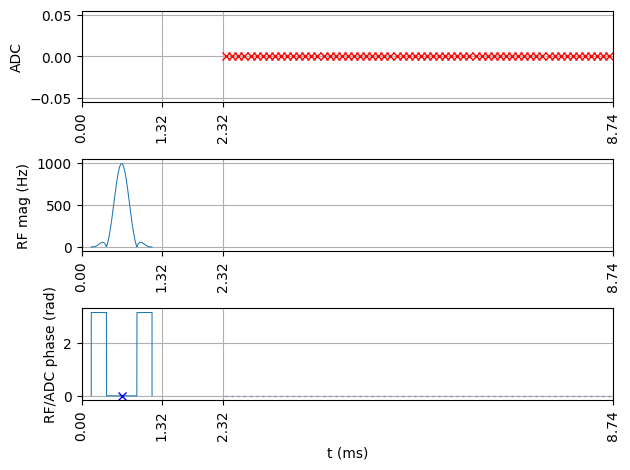

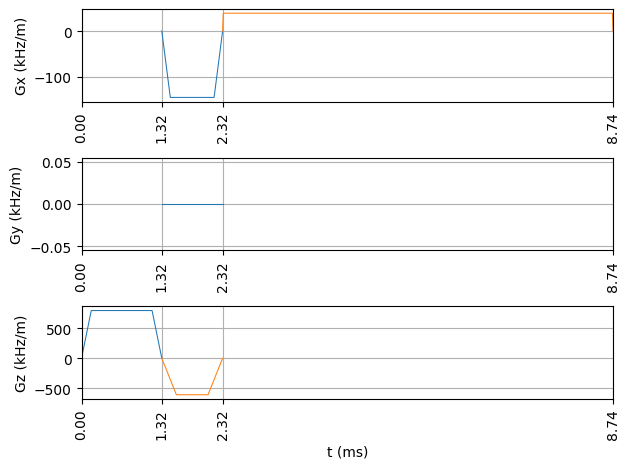

In [25]:
# CONSTRUCT SEQUENCE
# Create a new sequence object

seq.add_block(gx_pre, gy_0, gz_reph)

adc.delay=gx.rise_time
seq.add_block(adc,gx)
seq.plot(show_blocks=TRUE, time_disp='ms')

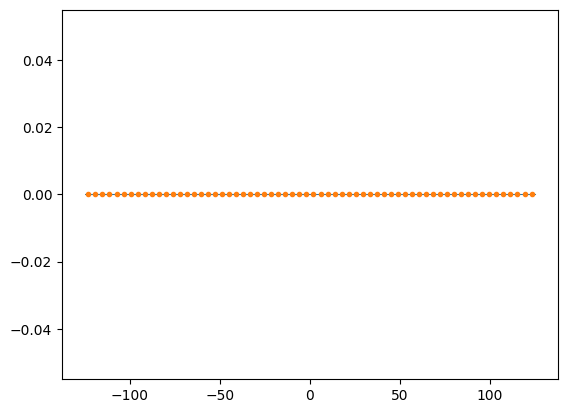

In [26]:
# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'.')

# GRE into 2D



*   Callculate timings for correct TR and TE.
*   Adding gradient spoil to fill each line in k-space.
*   Iterate each k-space line.






### Setup sequence

In [27]:
# 2D GRE - sequence
# DEFINE the sequence, FOV and resolution
fov=220e-3    # [m]
Nread=64
Nphase=Nread
TE=6e-3       # [s]
TR=10000e-3   # [s]


# Define rf event
# sinc pulse for excitation
rf, gz, _ = mr.make_sinc_pulse( flip_angle=90 * np.pi / 180, system=system, duration=1e-3, slice_thickness=5e-3, apodization=0.5, time_bw_product=4, phase_offset=0* np.pi / 180, return_gz=True, delay=100e-6,)
gz_reph =  mr.make_trapezoid(channel='z', area=-gz.area/2, duration=1e-3, system=system)


# Define ADC event and gradients
adc = mr.make_adc(num_samples=Nread, duration=5.12e-3, phase_offset=0*np.pi/180, system=system)
deltak = 1/fov

# readout gradient
gx = mr.make_trapezoid(channel='x', flat_area=Nread*deltak, rise_time=adc.delay,flat_time=adc.dwell*adc.num_samples, system=system)
gxPre = mr.make_trapezoid(channel='x', area=-gx.area/2, duration=1e-3, system=system)



## Gradient spoiling

In [28]:
# Gradient addition for spoiling
# Cut RO gradient into two parts for the optimal spoiler timing and use first part
gx1, _ = mr.split_gradient_at(grad=gx, time_point=gx.rise_time+gx.flat_time)
# gradient spoiling
gxSpoil = mr.make_extended_trapezoid_area(channel=gx.channel, grad_start=gx.amplitude, grad_end=0, area=2*Nread*deltak, system=system)[0]
gxSpoil.delay = mr.calc_duration(gx1)
gx_add = mr.add_gradients(grads=(gx1, gxSpoil),system=system)

## Timing calculations

In [29]:
# Calculate timing
delayTE = np.ceil((TE-mr.calc_duration(gxPre) - rf.shape_dur/2-rf.ringdown_time-adc.delay-adc.dwell*adc.num_samples/2)/seq.grad_raster_time)*seq.grad_raster_time
delayTR = np.ceil((TR - mr.calc_duration(rf) - delayTE - mr.calc_duration(gxPre) - mr.calc_duration(gx))/seq.grad_raster_time)*seq.grad_raster_time ;
assert(delayTE>=0)
assert(delayTR>=0)

## Iterate each line

In [30]:
# ======
# CONSTRUCT SEQUENCE
# ======
seq=mr.Sequence(system)

# Iterare for each line
for i in range(0, Nphase):
  # Block 1
  seq.add_block(rf, gz) #Block 1

  # Calculate gy for each line and respective gy_reph for Block 3
  gyPre = mr.make_trapezoid(channel='y',area=(i-Nphase/2)*deltak,
                            duration=mr.calc_duration(gxPre),system=system)
  gyReph = mr.scale_grad(gyPre, -1)
  gyReph.delay = mr.calc_duration(gx1)

  # Block 2
  seq.add_block(gxPre, gyPre, gz_reph)


  # Delay TE
  seq.add_block(mr.make_delay(delayTE))


  # Block 3
  seq.add_block(gx_add, adc, gyReph)

  # Delay TR
  seq.add_block(mr.make_delay(delayTR))


#Visualization and Export

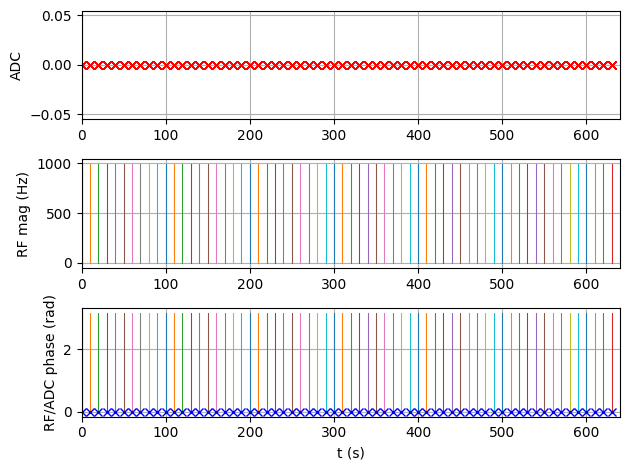

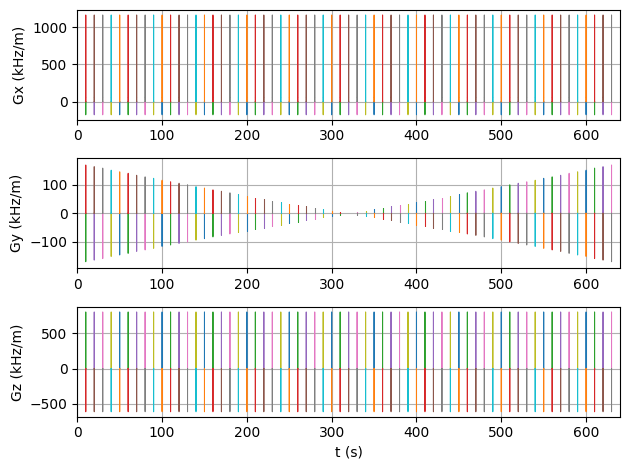

zoom in


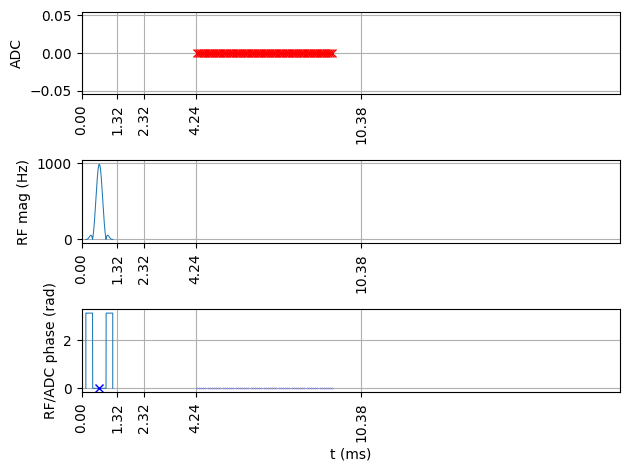

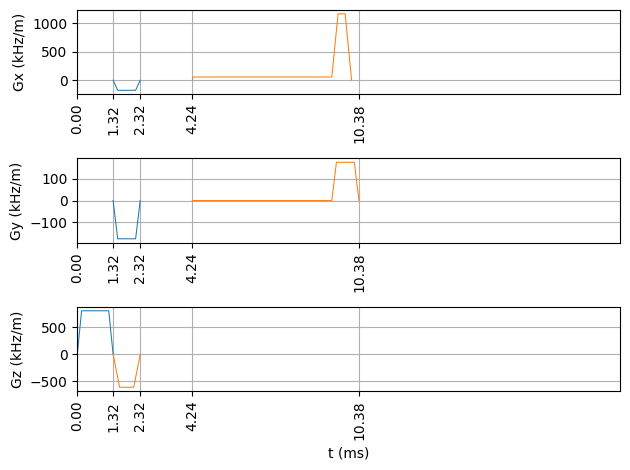

In [31]:
#@title plot sequence
# plot the entire sequence
seq.plot()

# plot just a small initial part
print('zoom in')
#seq.plot(time_range=[0, 0.002], time_disp="ms") #seq.plot(time_range=(0, TE*2))
seq.plot(time_range=(0, 0.02),show_blocks=TRUE, time_disp="ms")



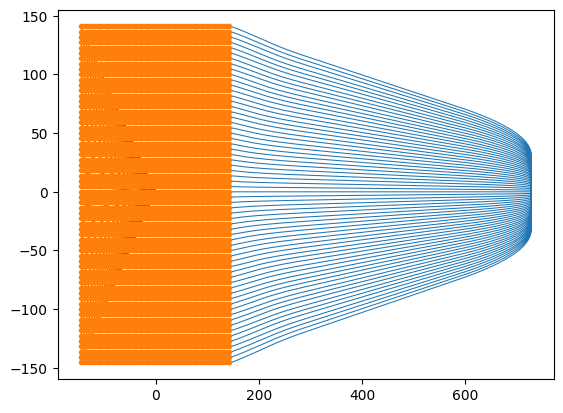

In [32]:
# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'.')

In [33]:
#@title write seq file and export
seq_filename='2D_GRE.seq'
seq.write(seq_filename)
from google.colab import files
files.download(seq_filename)  # Download locally

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>